In [4]:
import pandas as pd; pd.set_option('display.max_columns', 200)
import numpy as np
import scipy as sp

from datetime import datetime
from tqdm import tqdm
import holidays

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import os
import re
import sys

from xml.etree import ElementTree
from collections import Counter, OrderedDict
from tqdm import tqdm
import optuna



In [5]:
train = pd.read_csv('/kaggle/input/kaggle-pog-series-s01e04/train.csv')
train['date'] = pd.to_datetime(train['date'])

train_detailed = pd.read_csv('/kaggle/input/kaggle-pog-series-s01e04/train_detailed.csv')

test = pd.read_csv('/kaggle/input/kaggle-pog-series-s01e04/test.csv')
test['date'] = pd.to_datetime(test['date'])

sample_submission = pd.read_csv('/kaggle/input/kaggle-pog-series-s01e04/sample_submission.csv')


In [6]:
train.head(10)

,date,sleep_hours
0,2015-02-19,6.400000
1,2015-02-20,7.583333
2,2015-02-21,6.350000
3,2015-02-22,6.500000
4,2015-02-23,8.916667
5,2015-02-24,6.600000
6,2015-02-25,6.216667
7,2015-02-26,5.283333
8,2015-02-27,9.866667
9,2015-02-28,5.966667


In [7]:
train.describe()

,sleep_hours
count,2354.000000
mean,7.356560
std,2.213308
min,1.266667
25%,6.235417
50%,6.816667
75%,7.483333
max,17.433333


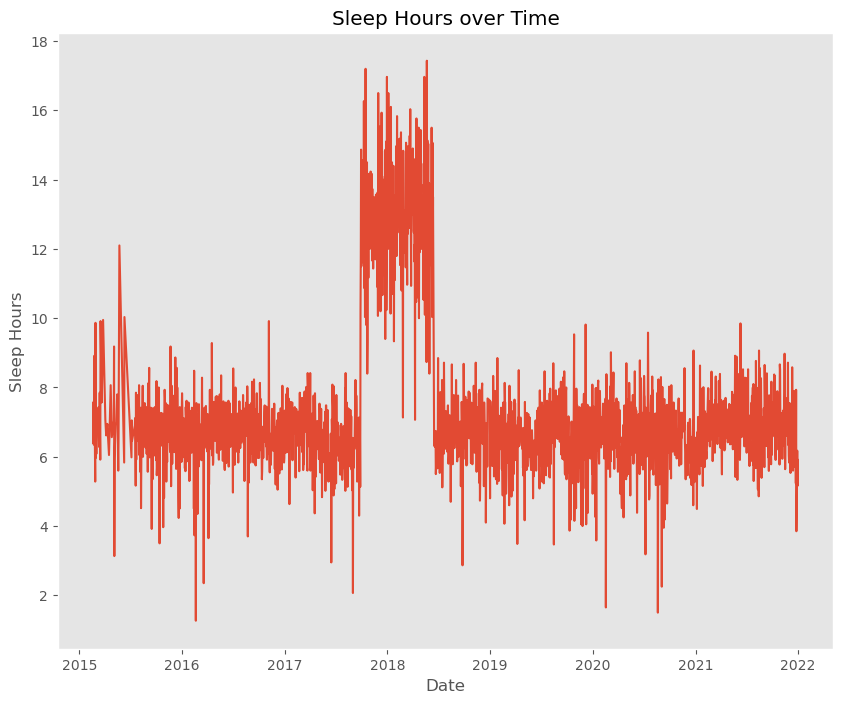

In [8]:

plt.figure(figsize=(10, 8))
sns.lineplot(data=train, x='date', y='sleep_hours')
plt.xlabel('Date')
plt.ylabel('Sleep Hours')
plt.title('Sleep Hours over Time')
plt.grid()


plt.show()

In [9]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py


sg = go.Scatter(
                    x = train.date,
                    y = train.sleep_hours,
                    mode = "lines",
                    line=dict(color='blue', width=2, dash='dash'))

data = [sg]
layout = dict(title='Sleep Hours over Time',
              xaxis=dict(title='Date', ticklen=5, zeroline=False),
              yaxis=dict(title='Sleep Hours'),
              height=400,
              width=800)
fig = dict(data=data, layout=layout)
iplot(fig)

In [10]:
sleep_over_13 = train[train.sleep_hours > 13]


min_date = sleep_over_13.date.min()
max_date = sleep_over_13.date.max()

print(f"Minimum date where sleep time was over 13 hours: {min_date}")
print(f"Maximum date where sleep time was over 13 hours: {max_date}")


Minimum date where sleep time was over 13 hours: 2017-09-29 00:00:00
Maximum date where sleep time was over 13 hours: 2018-06-12 00:00:00


In [11]:
mean_sleep_over_13 = sleep_over_13.sleep_hours.mean()

print(f"Mean for dates where sleep was over 13 hours: {mean_sleep_over_13}")


Mean for dates where sleep was over 13 hours: 14.246194225721784


In [12]:
mean_sleep_every_other = train.iloc[::2].sleep_hours.mean()

print(f"Mean sleep hours for every other date: {mean_sleep_every_other}")


Mean sleep hours for every other date: 7.3604219767771175


In [13]:
diff_mean = mean_sleep_over_13 / mean_sleep_every_other

print(f"Average difference between the mean sleep hours: {diff_mean}")


Average difference between the mean sleep hours: 1.9355132451196386


In [14]:
import scipy.stats as stats

hypothesized_mean = mean_sleep_every_other * 2

t_stat, p_value = stats.ttest_1samp(sleep_over_13.sleep_hours, hypothesized_mean)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")


t-statistic: -5.241599764213646
p-value: 6.503554263389588e-07


In [15]:
train_copy = train.copy()

doubled_hours = train_copy[(train_copy.date >= '2017-09-28') & (train_copy.date <= '2018-06-12')]

train_copy.loc[doubled_hours.index, 'sleep_hours'] = doubled_hours.sleep_hours / 2


In [16]:
train_copy.head(10)

,date,sleep_hours
0,2015-02-19,6.400000
1,2015-02-20,7.583333
2,2015-02-21,6.350000
3,2015-02-22,6.500000
4,2015-02-23,8.916667
5,2015-02-24,6.600000
6,2015-02-25,6.216667
7,2015-02-26,5.283333
8,2015-02-27,9.866667
9,2015-02-28,5.966667


In [17]:
train_copy.describe()

,sleep_hours
count,2354.000000
mean,6.652390
std,0.921892
min,1.266667
25%,6.150000
50%,6.666667
75%,7.216667
max,12.100000


In [18]:
new_sg = go.Scatter(
                    x = train_copy.date,
                    y = train_copy.sleep_hours,
                    mode = "lines",
                    line=dict(color='blue', width=2, dash='dash'))

data = [new_sg]
layout = dict(title='Sleep Hours over Time',
              xaxis=dict(title='Date', ticklen=5, zeroline=False),
              yaxis=dict(title='Sleep Hours'),
              height=400,
              width=800)
fig = dict(data=data, layout=layout)
iplot(fig)

In [19]:
def get_holidays(df):
    years_list = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

    holiday_US = holidays.CountryHoliday('US', years=years_list)
    holiday_dict = holiday_US.copy()

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')

    return df.drop(columns=['holiday_name'])


In [20]:
import holidays

less_than_3 = train_copy[train_copy.sleep_hours < 3]

less_than_3 = get_holidays(less_than_3).copy()
less_than_3.loc[:, 'is_holiday'] = less_than_3.is_holiday.astype(int)

holiday_df = pd.DataFrame({'date': holidays.US(years=[2016, 2017, 2018, 2019, 2020]).keys()})

less_than_3['prev_day_holiday'] = (less_than_3.date - pd.Timedelta(days=1)).isin(holiday_df['date']).astype(int)
less_than_3['next_day_holiday'] = (less_than_3.date + pd.Timedelta(days=1)).isin(holiday_df['date']).astype(int)
less_than_3['is_holiday_adjacent'] = (less_than_3.is_holiday == 1) | (less_than_3.prev_day_holiday == 1) | (less_than_3.next_day_holiday == 1)

less_than_3_holiday_adjacent = less_than_3[less_than_3.is_holiday_adjacent == 1]



print(less_than_3_holiday_adjacent)

           date  sleep_hours  is_holiday  prev_day_holiday  next_day_holiday  \
1687 2020-02-17         1.65           1                 0                 0   

      is_holiday_adjacent  
1687                 True  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [21]:
weekends = train_copy[(train_copy.date.dt.dayofweek == 5) | (train_copy.date.dt.dayofweek == 6)]

avg_sleep_weekends = weekends.sleep_hours.mean()

print(f"Average sleep on weekends: {avg_sleep_weekends:.2f} hours")


Average sleep on weekends: 6.87 hours


In [22]:
avg_sleep_by_day = train_copy.groupby(train_copy['date'].dt.strftime('%A'))['sleep_hours'].mean()

print(avg_sleep_by_day)

date
Friday       6.661512
Monday       6.452844
Saturday     6.946573
Sunday       6.799233
Thursday     6.664778
Tuesday      6.479463
Wednesday    6.563088
Name: sleep_hours, dtype: float64


In [23]:
z_scores = (train_copy['sleep_hours'] - train_copy['sleep_hours'].mean()) / train_copy['sleep_hours'].std()

outliers = abs(z_scores) > 3

outliers_df = train_copy[outliers]


In [24]:
outliers_df.head(10)

,date,sleep_hours
8,2015-02-27,9.866667
21,2015-03-17,9.916667
24,2015-03-26,9.950000
33,2015-05-05,3.133333
41,2015-05-23,12.100000
44,2015-06-10,10.033333
134,2015-10-13,3.500000
258,2016-02-14,3.733333
263,2016-02-19,1.266667
288,2016-03-18,2.350000


In [25]:
outliers_df.describe()

,sleep_hours
count,32.000000
mean,5.434896
std,3.494341
min,1.266667
25%,3.087500
50%,3.616667
75%,9.825000
max,12.100000


In [26]:
from scipy.stats import zscore

train_copy['sleep_zscore'] = zscore(train_copy['sleep_hours'])

outliers = train_copy[abs(train_copy['sleep_zscore']) > 3]

train_copy = train_copy[abs(train_copy['sleep_zscore']) <= 3].copy()

train_copy = train_copy.drop(columns=['sleep_zscore'])

In [27]:
train_copy.head(10)

,date,sleep_hours
0,2015-02-19,6.400000
1,2015-02-20,7.583333
2,2015-02-21,6.350000
3,2015-02-22,6.500000
4,2015-02-23,8.916667
5,2015-02-24,6.600000
6,2015-02-25,6.216667
7,2015-02-26,5.283333
9,2015-02-28,5.966667
10,2015-03-01,7.400000


In [28]:
train_copy.describe()

,sleep_hours
count,2322.000000
mean,6.669168
std,0.823285
min,3.916667
25%,6.166667
50%,6.666667
75%,7.216667
max,9.283333


In [29]:
import holidays

holiday_df = pd.DataFrame({'date': holidays.US(years=[2016, 2017, 2018, 2019, 2020, 2021]).keys()})

train_copy['prev_day_holiday'] = (train_copy.date - pd.Timedelta(days=1)).isin(holiday_df['date']).astype(int)
train_copy['is_holiday'] = train_copy.date.isin(holiday_df['date']).astype(int)

train_copy = train_copy[(train_copy.prev_day_holiday == 0) & (train_copy.is_holiday == 0)].copy()

train_copy = train_copy.drop(columns=['prev_day_holiday', 'is_holiday'])


In [30]:
# our data is looking a lot better. We might have removed too much of the outlier data. But we are going to go with it

new_sg = go.Scatter(
                    x = train_copy.date,
                    y = train_copy.sleep_hours,
                    mode = "lines",
                    line=dict(color='blue', width=2, dash='dash'))

data = [new_sg]
layout = dict(title='Sleep Hours over Time',
              xaxis=dict(title='Date', ticklen=5, zeroline=False),
              yaxis=dict(title='Sleep Hours'),
              height=400,
              width=800)
fig = dict(data=data, layout=layout)
iplot(fig)


In [31]:
# Dropping every date prior to 2020

train_copy = train_copy.loc[train_copy['date'] >= '2020-01-01']

P =  27


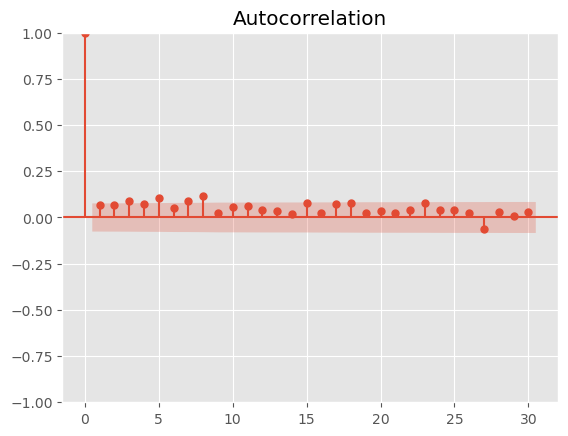

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf


plot_acf(train_copy['sleep_hours'], lags=30)


acf_vals, confint = acf(train_copy['sleep_hours'], nlags=30, alpha=0.05)


peaks = (np.abs(acf_vals[1:]) > confint[1:, 1])
if any(peaks):
    highest_peak = np.argmax(peaks) + 1
    print("P = ", highest_peak)
else:
    print("No significant peak found")



/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



P =  27


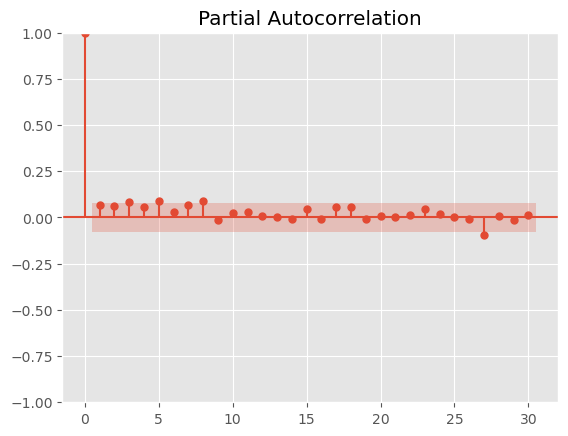

In [33]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

plot_pacf(train_copy['sleep_hours'], lags=30)

pacf_vals, confint = pacf(train_copy['sleep_hours'], nlags=30, alpha=0.05)

peaks = (np.abs(pacf_vals) > confint[:, 1])
if peaks.sum() > 0:
    highest_peak = np.argmax(peaks)
    P = highest_peak
    print("P = ", P)
else:
    print("No significant peak found.")


d = 2


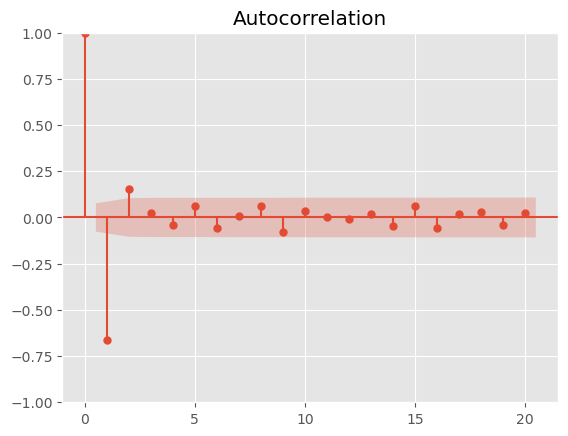

In [34]:
from statsmodels.graphics.tsaplots import plot_acf


second_diff = train_copy['sleep_hours'].diff().diff()

plot_acf(second_diff.dropna(), lags=20)


d = 0
while True:
    acf_vals, confint = acf(train_copy['sleep_hours'].diff().diff().dropna(), nlags=20, alpha=0.05)
    peaks = (np.abs(acf_vals) > confint[:, 1])
    if not peaks.any() or d == 2:
        break
    d += 1
print("d =", d)


Q = 20


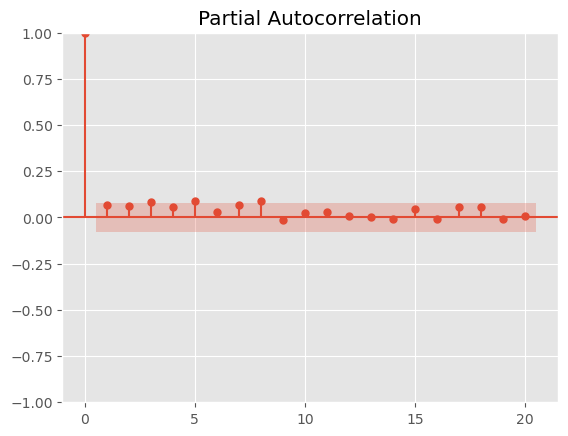

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train_copy['sleep_hours'], lags=20)

pacf_vals, confint = pacf(train_copy['sleep_hours'], nlags=20, alpha=0.05)

peaks = (np.abs(pacf_vals) > confint[:, 1])
last_peak = len(peaks) - np.argmax(peaks[::-1]) - 1


Q = last_peak
print("Q =", Q)


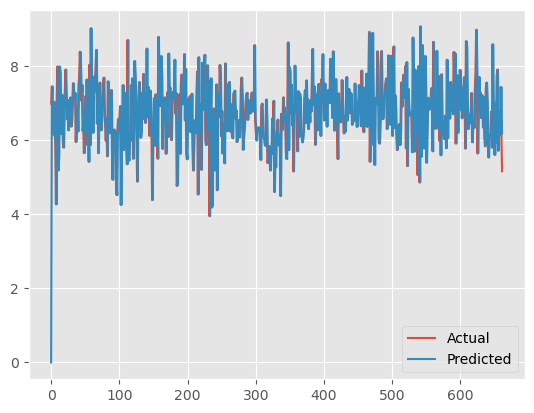

In [36]:
#the numbers from testing... but they arent as good as my initial estimates

from statsmodels.tsa.arima.model import ARIMA

data = train_copy['sleep_hours'].values

# numbers from the above correlation tests
# p = 27
# d = 2
# q = 20

# Numbers from acf tests below
p = 0
d = 1
q = 0


model = ARIMA(data, order=(p, d, q))

model_fit = model.fit()

predictions = model_fit.predict(start=0, end=len(data)-1)


import matplotlib.pyplot as plt
plt.plot(data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


In [ ]:
# need to test more...

# from statsmodels.tsa.arima.model import ARIMA

# data = train_copy['sleep_hours'].values

# p = 5
# d = 1
# q = 27


# model = ARIMA(data, order=(p, d, q))

# model_fit = model.fit()

# predictions = model_fit.predict(start=0, end=len(data)-1)


# import matplotlib.pyplot as plt
# plt.plot(data, label='Actual')
# plt.plot(predictions, label='Predicted')
# plt.legend()
# plt.show()

In [38]:
from statsmodels.tsa.arima.model import ARIMA

data = train_copy['sleep_hours'].values

start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 3, 16)
date_range = pd.date_range(start_date, end_date, freq='D')


predictions_df = pd.DataFrame({'date': date_range})

data = train_copy['sleep_hours'].values

# old best values
# p = 5
# d = 1
# q = 27

# New best values, but only with data from 2020 +
# p = 0
# d = 0
# q = 0

#testing the results from the above tests. 1, 1, 1 seems to be the best values here
p = 0
d = 0
q = 0

model = ARIMA(data, order=(p, d, q))
model_fit = model.fit()

predictions = model_fit.predict(start=0, end=len(data)+len(date_range)-1)

predictions_df['sleep_hours'] = predictions[-len(date_range):]

predictions_df.set_index('date', inplace=True)

In [39]:
# So far best results have been .6 Continuing to test and tune to match testing data.


from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay


cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date)

bday = CustomBusinessDay(calendar=cal)

predictions_df['holiday'] = predictions_df.index.isin(holidays)

for holiday in holidays:
    day_of = holiday
    day_after = holiday + bday
    

    if day_of in predictions_df.index:
        predictions_df.loc[day_of, 'sleep_hours'] += 0.6
    
    if day_after in predictions_df.index:
        predictions_df.loc[day_after, 'sleep_hours'] -= 0.6



In [40]:
predictions_df = predictions_df.reset_index()

In [41]:
predictions_df.drop('holiday', axis=1, inplace=True)

In [42]:
predictions_df.head()

,date,sleep_hours
0,2022-01-01,5.158333
1,2022-01-02,5.158333
2,2022-01-03,5.158333
3,2022-01-04,5.158333
4,2022-01-05,5.158333


In [43]:
# calculate avg by day of the week
avg_sleep = predictions_df.groupby(predictions_df['date'].dt.strftime('%A'))['sleep_hours'].mean()


print(avg_sleep)


date
Friday       5.158333
Monday       5.244048
Saturday     5.158333
Sunday       5.158333
Thursday     5.167857
Tuesday      5.063095
Wednesday    5.158333
Name: sleep_hours, dtype: float64


In [44]:
# compare to the old averages
avg_sleep_by_day = train_copy.groupby(train_copy['date'].dt.strftime('%A'))['sleep_hours'].mean()


print(avg_sleep_by_day)



date
Friday       6.749638
Monday       6.686905
Saturday     7.009694
Sunday       6.832732
Thursday     6.861170
Tuesday      6.487689
Wednesday    6.705556
Name: sleep_hours, dtype: float64


In [45]:
predictions_df.describe()

,sleep_hours
count,440.000000
mean,5.158333
std,0.140289
min,4.558333
25%,5.158333
50%,5.158333
75%,5.158333
max,5.758333


In [46]:
train_copy.describe()

,sleep_hours
count,662.000000
mean,6.765911
std,0.852124
min,3.950000
25%,6.216667
50%,6.775000
75%,7.300000
max,9.066667


In [47]:
submission = predictions_df.reset_index(drop=True)

In [48]:
predictions_df.head()

,date,sleep_hours
0,2022-01-01,5.158333
1,2022-01-02,5.158333
2,2022-01-03,5.158333
3,2022-01-04,5.158333
4,2022-01-05,5.158333


In [49]:
submission.tail()

,date,sleep_hours
435,2023-03-12,5.158333
436,2023-03-13,5.158333
437,2023-03-14,5.158333
438,2023-03-15,5.158333
439,2023-03-16,5.158333


In [50]:
missing_dates = submission[~submission['date'].isin(sample_submission['date'])]['date']
print(missing_dates)


8     2022-01-09
9     2022-01-10
10    2022-01-11
11    2022-01-12
12    2022-01-13
13    2022-01-14
14    2022-01-15
15    2022-01-16
16    2022-01-17
17    2022-01-18
33    2022-02-03
99    2022-04-10
129   2022-05-10
179   2022-06-29
205   2022-07-25
220   2022-08-09
221   2022-08-10
254   2022-09-12
289   2022-10-17
335   2022-12-02
359   2022-12-26
Name: date, dtype: datetime64[ns]


In [51]:
missing_dates = submission[~submission['date'].isin(sample_submission['date'])]['date']

submission = submission[~submission['date'].isin(missing_dates)]


In [52]:
submission = submission.reset_index(drop=True)


In [53]:
print("Number of unique dates in submission:", len(submission['date'].unique()))
print("Number of unique dates in sample submission:", len(sample_submission['date'].unique()))


Number of unique dates in submission: 419
Number of unique dates in sample submission: 419


In [54]:
submission.dropna(subset=['sleep_hours'])

,date,sleep_hours
0,2022-01-01,5.158333
1,2022-01-02,5.158333
2,2022-01-03,5.158333
3,2022-01-04,5.158333
4,2022-01-05,5.158333
...,...,...
414,2023-03-12,5.158333
415,2023-03-13,5.158333
416,2023-03-14,5.158333
417,2023-03-15,5.158333


In [55]:
submission.drop_duplicates(subset=['date'])

,date,sleep_hours
0,2022-01-01,5.158333
1,2022-01-02,5.158333
2,2022-01-03,5.158333
3,2022-01-04,5.158333
4,2022-01-05,5.158333
...,...,...
414,2023-03-12,5.158333
415,2023-03-13,5.158333
416,2023-03-14,5.158333
417,2023-03-15,5.158333


In [56]:
submission.head()

,date,sleep_hours
0,2022-01-01,5.158333
1,2022-01-02,5.158333
2,2022-01-03,5.158333
3,2022-01-04,5.158333
4,2022-01-05,5.158333


In [57]:
submission.tail()

,date,sleep_hours
414,2023-03-12,5.158333
415,2023-03-13,5.158333
416,2023-03-14,5.158333
417,2023-03-15,5.158333
418,2023-03-16,5.158333


In [58]:
print("Number of unique dates in submission:", len(submission['date'].unique()))
print("Number of unique dates in sample submission:", len(sample_submission['date'].unique()))


Number of unique dates in submission: 419
Number of unique dates in sample submission: 419


In [59]:
submission.to_csv('submission.csv', index = False)